# Timeliness for news data


## Imports

In [ ]:
!pip install transformers

In [ ]:
#!pip install bertopic

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import re
from tqdm import tqdm

import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from transformers import  DistilBertForTokenClassification, DistilBertTokenizer, DistilBertModel

from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score
#from bertopic import BERTopic
import joblib

import numpy
from sklearn.metrics.pairwise import cosine_similarity
import torch

import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from scipy.spatial.distance import squareform

## Read data

In [ ]:
#data=pd.read_csv('/content/drive/MyDrive/DQ/RedditNews.csv')

In [ ]:
#data.head()

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...


In [ ]:
#data2=pd.read_csv("/content/drive/MyDrive/DQ/upload_DJIA_table.csv")

In [ ]:
#data2.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


In [ ]:
#merge=data.merge(data2,how="inner",on="Date")

In [ ]:
#merge.head()

,Date,News,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,A 117-year-old woman in Mexico City finally re...,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-07-01,IMF chief backs Athens as permanent Olympic host,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
2,2016-07-01,"The president of France says if Brexit won, so...",17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141


In [ ]:
#merge.size

397744

In [ ]:
#merge['Date_new']=pd.to_datetime(merge['Date'])

## Topics

**BERt** topic
https://github.com/MaartenGr/BERTopic
https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [ ]:
def generate_topics(merge):
  topic_model = BERTopic(language="english", calculate_probabilities=False, verbose=True)
  topics = topic_model.fit_transform(merge['News'])
  joblib.dump(topic_model, '/content/drive/MyDrive/DQ/topic_model.pkl')
  merge['topics']=topic_model.topics_
  merge=merge[merge['topics']>-1] # -1 is undefined topic
  joblib.dump(merge, '/content/drive/MyDrive/DQ/merge.pkl')
generate_topics(merge)

In [ ]:
#Examine topics
topic_model=joblib.load('/content/drive/MyDrive/DQ/topic_model.pkl')
freq = topic_model.get_topic_info(); freq.head(5)
topic_model.get_topic(1)  # Select the most frequent topic
topic_model.topics_[:10] #predicted topics of first 10 documents
topic_model.visualize_barchart(top_n_topics=20)
topic_model.topic_labels_

RuntimeError: ignored

In [ ]:
#merge=joblib.load('/content/drive/MyDrive/DQ/merge.pkl')

## Similarity

In [ ]:
'''distill_uncased = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
modelDistil= DistilBertModel.from_pretrained('distilbert-base-uncased')

In [ ]:
'''# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

In [ ]:
'''def prepare_apply_model_GPU(tokenizer, text, model, length):
  model.to(device);
  input=torch.tensor([tokenizer.encode(text, add_special_tokens=True, padding='max_length',truncation='longest_first', max_length=length)]).to(device)
  with torch.no_grad():
    outputs = model(input)
  embeddings = outputs.last_hidden_state[0][0].cpu().numpy()
  return embeddings

In [ ]:
'''resultdball=[]
i=0
for date, text, topic in merge[['Date_new','News', 'topics']].values:
  embeddings=prepare_apply_model_GPU(distill_uncased, text, modelDistil, 512)
  resultdball.append([topic,date,text,embeddings])
  #print(i)
  i=i+1

In [ ]:
'''finalresult=pd.DataFrame(resultdball, columns=['Topic','Date', 'News', 'embeddings'])

In [ ]:
'''finalresult.head()

In [ ]:
'''joblib.dump(finalresult, '/content/drive/MyDrive/DQ/embeddings_ll.pkl')

In [ ]:
finalresult=joblib.load('/content/drive/MyDrive/DQ/embeddings_ll.pkl')

In [ ]:
finalresult.head()

,Topic,Date,News,embeddings
0,58,2016-07-01,IMF chief backs Athens as permanent Olympic host,"[0.085457966, 0.0037823897, 0.22491361, 0.2174..."
1,51,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...,"[0.101253465, 0.00812812, 0.20945066, 0.226346..."
2,140,2016-07-01,Brazil: Huge spike in number of police killing...,"[0.10223168, -0.03164121, 0.20840168, 0.226542..."
3,17,2016-07-01,Austria's highest court annuls presidential el...,"[0.049239065, -0.011678931, 0.19130395, 0.2192..."
4,191,2016-07-01,"Facebook wins privacy case, can track any Belg...","[0.109557085, 0.014072897, 0.2136854, 0.203175..."


In [ ]:
finalresult.shape

(31289, 4)

In [ ]:
def calc_similarity(finalresult):
  similarity = cosine_similarity(finalresult['embeddings'].apply(pd.Series))
  similarity2=pd.np.tril(similarity)
  np.fill_diagonal(similarity2, 0)
  similarity3=pd.DataFrame(similarity2, columns=range(0,len(finalresult)), index=range(0,len(finalresult)))
  joblib.dump(similarity3, '/content/drive/MyDrive/DQ/similarity3.pkl')
calc_similarity(finalresult)

In [ ]:
similarity3=joblib.load('/content/drive/MyDrive/DQ/similarity3.pkl')

In [ ]:
def generateData(topic, finalresult, similarity3, threshold):
  similarity3_1=similarity3[finalresult.index[finalresult['Topic'] == topic].tolist()].loc[finalresult.index[finalresult['Topic'] == topic].tolist()]
  similarity3_1_sorted=similarity3_1.sort_values(by=similarity3_1.columns.to_list(),ascending=False)
  pairs = similarity3_1_sorted.stack()
  indeces=list(pairs[pairs.abs().gt(threshold)].index)
  res_1=[[((finalresult['Date'].loc[j]-finalresult['Date'].loc[i]).days),finalresult['News'].loc[[i,j]],similarity3_1_sorted.loc[i,j]] for (i,j) in indeces]
  joblib.dump(res_1, '/content/drive/MyDrive/DQ/sortedSimilarity_'+str(topic)+'_'+str(threshold)+'.pkl')
  res1_df=pd.DataFrame(res_1,columns=['Date', 'News', 'Similarity']).sort_values(by='Similarity',ascending=False)
  #res1_df.to_csv('/content/drive/MyDrive/DQ/sortedSimilarity_'+str(topic)+'_'+str(threshold)+'.csv')
  return res1_df
res_1=generateData(9, finalresult, similarity3, 0.999)

In [ ]:
res_1.sort_values(by='Similarity',ascending=False)['News'].iloc[0].values

array(['7.9 earthquake strikes off the coast of Costa Rica',
       '7.9 Earthquake off the coast of Costa Rica'], dtype=object)

same say, same topic

In [ ]:
res_1.sort_values(by='Similarity',ascending=False)['News'].iloc[1].values

array(['Powerful 7.8 earthquake hits New Zealand',
       '6.9 earthquake hits Wellington New Zealand'], dtype=object)

In [ ]:
res_1.sort_values(by='Similarity',ascending=False)['News'].iloc[4].values

array(['Major 7.7 quake strikes off Papua New Guinea, tsunami warning issued',
       '7.4 quake hits near Papua New Guinea, tsunami warning issued'],
      dtype=object)

same topic, time long

In [ ]:
res_1.sort_values(by='Similarity',ascending=False)['News'].iloc[2].values

array(['Magnitude 7.4 earthquake strikes off the coast of El \r\nSalvador',
       '7.9 earthquake strikes off the coast of Costa Rica'], dtype=object)

Same topic, time close, but different entities

In [ ]:
res_1.sort_values(by='Similarity',ascending=False)['News'].iloc[5].values

array(['Ecuador hit by 6.9-magnitude earthquake',
       'Japan hit by 6.3-magnitude earthquake'], dtype=object)

entities and date not valid
[{'entity': 'B-LOC', 'score': 0.99984336, 'index': 1, 'word': 'Ecuador', 'start': 0, 'end': 7}]
[{'entity': 'B-LOC', 'score': 0.99982077, 'index': 1, 'word': 'Japan', 'start': 0, 'end': 5}]
==> same entitity and same word

In [ ]:
res_1.sort_values(by='Similarity',ascending=False)['News'].iloc[6].values

array(['Magnitude 7.4 earthquake strikes off the coast of El \r\nSalvador',
       '7.9 Earthquake off the coast of Costa Rica'], dtype=object)

In [ ]:
res_1.sort_values(by='Similarity',ascending=False).head(20)

,Date,News,Similarity
22251,0,15347 7.9 earthquake strikes off the coast ...,0.999922
7599,771,20133 Powerful 7.8 earthquake hits New Ze...,0.999830
22385,9,15450 Magnitude 7.4 earthquake strikes off ...,0.999792
748,14,17509 Japan Earthquake: Before and After [p...,0.999755
14080,36,4973 Major 7.7 quake strikes off Papua New ...,0.999753
6057,1310,23721 Ecuador hit by 6.9-magnitude earthqua...,0.999736
22384,9,15450 Magnitude 7.4 earthquake strikes off ...,0.999700
22195,313,18838 6.9 Magnitude Earthquake Near the Coa...,0.999690
22196,313,18838 6.9 Magnitude Earthquake Near the Coa...,0.999680
22176,1420,18838 6.9 Magnitude Earthquake Near the Coa...,0.999679


In [ ]:
res_10=generateData(10, finalresult, similarity3, 0.999)

In [ ]:
res_10.head()

,Date,News,Similarity
47,3,17707 RAF helicopter death revelation leads...,1.000000
55,275,"28484 b""'torture tape' sheikh arrested but ...",0.999625
86,1480,"22925 Torture, killing, children shot and ...",0.999520
68,381,"29571 b""The Torture Ban that Doesn't ...",0.999511
43,974,27845 b'Revealed the secret torture eviden...,0.999499


In [ ]:
res_10.sort_values(by='Similarity',ascending=False)['News'].iloc[0]

'17707    RAF helicopter death revelation leads to secre...\n17658    RAF helicopter death revelation leads to secre...\nName: News, dtype: object'

In [ ]:
res_10.sort_values(by='Similarity',ascending=False)['News'].iloc[1]

'28484    b"\'torture tape\' sheikh arrested but will prob...\n25679    b\'The torture memos show how illegal wars turn...\nName: News, dtype: object'

time long, topic similar

In [ ]:
res_10.sort_values(by='Similarity',ascending=False)['News'].iloc[2]

"22925    Torture, killing, children shot  and how the U...\n6453     'We crossed the line', US admits to UN anti-to...\nName: News, dtype: object"

In [ ]:
res_10.sort_values(by='Similarity',ascending=False).head(20)

,Date,News,Similarity
47,3,17707 RAF helicopter death revelation leads...,1.000000
55,275,"28484 b""'torture tape' sheikh arrested but ...",0.999625
86,1480,"22925 Torture, killing, children shot and ...",0.999520
68,381,"29571 b""The Torture Ban that Doesn't ...",0.999511
43,974,27845 b'Revealed the secret torture eviden...,0.999499
70,106,"29571 b""The Torture Ban that Doesn't ...",0.999481
6,218,27085 b'Torture techniques used on suspecte...,0.999473
97,253,13160 Red Cross to visit Guantanamo as hung...,0.999449
69,163,"29571 b""The Torture Ban that Doesn't ...",0.999447
54,1031,"28484 b""'torture tape' sheikh arrested but ...",0.999402


In [ ]:
res_7=generateData(7, finalresult, similarity3, 0.999)

In [ ]:
res_7.sort_values(by='Similarity',ascending=False)['News'].iloc[0].values

array(["b'The Pirate Bay FTW!'",
       'Why we are breaking the Pirate Bay ban\r\n'], dtype=object)

In [ ]:
res_7.sort_values(by='Similarity',ascending=False)['News'].iloc[1].values

array(["b'The Pirate Bay FTW!'",
       'The Pirate Bay: PIPA/SOPA Wont Stop Us!'], dtype=object)

topic same, time not valid

In [ ]:
res_7.sort_values(by='Similarity',ascending=False)['News'].loc[96].values

array(["b'The Pirate Bay FTW!'", "b'Pirate Bay lawyer wants a retrial'"],
      dtype=object)

In [ ]:
res_7.sort_values(by='Similarity',ascending=False)['News'].loc[145].values

array([' Merkel shaken at state poll as Pirate Party surges',
       'Pirate Bay allowed to continue operating by Sweeden Court'],
      dtype=object)

time and topic

In [ ]:
res_7.sort_values(by='Similarity',ascending=False).head(20)

,Date,News,Similarity
89,1177,28723 b'The Pirate Bay ...,0.999578
91,1001,28723 b'The Pirate Bay FTW...,0.999577
32,104,28463 b'Swedish Bank to Freeze Accounts of ...,0.999555
92,524,28723 b'The Pirate Bay FTW!...,0.999539
94,114,28723 b'The Pirate Bay FTW!' 27464...,0.999504
106,653,23245 The Pirate Bay Appeal Starts Tomo...,0.999476
65,1063,"27464 b'And now, the Pirate Part...",0.999457
121,949,16578 BBC News - The Pirate Bay hit by...,0.999443
140,161,28757 b'PIRATE BAY FOUND G...,0.999436
4,110,18059 Pirate Party boarding German politics...,0.999423


## Named Entity recognition

In [ ]:
tokenizer_ner = AutoTokenizer.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
# https://huggingface.co/models?pipeline_tag=token-classification&sort=trending&search=camembert
model_ner = AutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
nlp = pipeline("ner", model=model_ner, tokenizer=tokenizer_ner)

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
pd.options.display.max_colwidth = 500

In [ ]:
def generate_uniform_data(finalresult, topic,  similarity3, percent):
  similarity3_1=similarity3[finalresult.index[finalresult['Topic'] == topic].tolist()].loc[finalresult.index[finalresult['Topic'] == topic].tolist()]
  similarity3_1_sorted=similarity3_1.sort_values(by=similarity3_1.columns.to_list(),ascending=False)
  pairs = similarity3_1_sorted.stack()
  indeces=list(pairs[pairs.abs().gt(0)].index)
  res_1=[[((finalresult['Date'].loc[j]-finalresult['Date'].loc[i]).days),finalresult['News'].loc[[i,j]],similarity3_1_sorted.loc[i,j]] for (i,j) in indeces]
  res1_df=pd.DataFrame(res_1,columns=['Date', 'News', 'Similarity']).sample(frac=percent, random_state=1)
  joblib.dump(res1_df, '/content/drive/MyDrive/DQ/similarity_all_no_NER'+str(topic)+'_'+n+'.pkl')
  res1_df.to_csv('/content/drive/MyDrive/DQ/similarity_all_no_NER'+str(topic)+'_'+n+'.csv')
  return res1_df

In [ ]:
finalresult['Topic'].describe()

count    31289.000000
mean       128.220972
std        146.173892
min          0.000000
25%         12.000000
50%         68.000000
75%        201.000000
max        579.000000
Name: Topic, dtype: float64

In [ ]:
for t in range(10):
  generate_uniform_data(finalresult, t,  similarity3,1.0)


NameError: ignored

<Axes: >

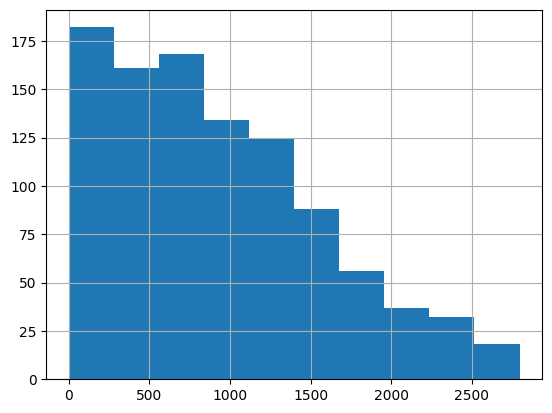

In [ ]:
res_8['Date'].hist()

In [ ]:
res_9=generate_uniform_data(finalresult, 9,  similarity3)

In [ ]:
res_8.shape

(1000, 3)

In [ ]:
def generate_Ner(topic):
  res=joblib.load('/content/drive/MyDrive/DQ/similarity_all_no_NER'+str(topic)+'_'+'.pkl')
  model=[[nlp(item) for item in text.replace("b'","")] for text in res['News'].values]
  ff=[[[s if len(s)>0 else 0] for s in m] for m in model]
  dd=[[[t['entity']+t['word'] for t in s[0]] if s[0]!=0 else 0 for s in m] for m in ff]
  res['entity']=[(set(d[0])==set(d[1])) if not (isinstance(d[0], int) or isinstance(d[1], int)) else 0 for d in dd]
  joblib.dump(res, '/content/drive/MyDrive/DQ/similarity_all_NER_'+str(topic)+'.pkl')
  res.to_csv('/content/drive/MyDrive/DQ/similarity_all_NER_'+str(topic)+'.csv')
  return res

In [ ]:
res_8_NER=generate_Ner(8)

KeyboardInterrupt: ignored

In [ ]:
res_8_NER.head()

,Date,News,Similarity,entity
20072,885,"9963 The U.S. Army tested biological weapons in Okinawa in the early 1960s, when the prefecture was still under U.S. rule, according to U.S. documents obtained by Kyodo News. 148 Elderly Japanese, among the world's richest retirees, are flocking to inheritance advisers, tackling historical taboos on discussing death and providing a rare avenue of growth for the country's brokerages and banks. Name: News, dtype: object",0.996011,False
5828,172,"29245 b'Japan is a major force in global business, culture and technologyyet in some ways it is governed like a banana republic. Why?' 27377 b'Australian woman, residing in Japan was a victim of a violent rape by American servicemen. Japanese police made no attempt to preserve urine sample, sperm or DNA on her body. W...",0.986744,False
2422,1522,"21797 The Last POW - story of a Japanese man who has been in Soviet Union since he was captured during WWII. 4854 Japanese admit conducting wartime vivisection on captured Americans at Kyushu Imperial University Name: News, dtype: object",0.982952,False
35695,1653,"22803 Lonely carnage abounds in Japan's 'suicide forest' - CNN.com 4474 Japan recognises Niue as a country with 1,611 inhabitants Name: News, dtype: object",0.987725,False
42100,1380,"29050 b'Japanese ""Suicide Forest""' 14139 Official in Japan's new government hints at revising apology to wartime sex slaves Name: News, dtype: object",0.996531,False


In [ ]:
res_9_NER=generate_Ner(9)

In [ ]:
res_9_NER.head()

,Date,News,Similarity,entity
17309,483,"25399 b'Breaking: Second Earthquake Strikes Chile - Magnitude 7.2' 20133 Powerful 7.8 earthquake hits New Zealand Name: News, dtype: object",0.998422,False
16486,564,"27250 b'Indonesia quake death toll at 46, likely to rise' 21331 Japanese fury at sensationalist foreign reporting of earthquake Name: News, dtype: object",0.997284,False
36440,246,"27511 b'Two Quakes Rock Indian Ocean, Japan Less Than 15 Minutes Apart....Triggering a Tsunami Warning.' 25074 b'Glacier breaks in Peru, causing tsunami in Andes' Name: News, dtype: object",0.984424,False
41251,538,"26995 b""Indonesia's latest earthquake disaster - A correspondent on the ground in Sumatra weighs in on fear, folklore and desperate rescue efforts"" 21298 Japan's Quake Damage May Swell to $309 Billion, Four Katrinas Name: News, dtype: object",0.979711,False
14362,85,"21289 Japanese man dons scuba suit and swims through tsunami to rescue wife 20345 Japan: three months after the quake Name: News, dtype: object",0.988459,False


In [ ]:
def generate_Ner_similarity(finalresult, topic,  similarity3, threshold):
  similarity3_1=similarity3[finalresult.index[finalresult['Topic'] == topic].tolist()].loc[finalresult.index[finalresult['Topic'] == topic].tolist()]
  similarity3_1_sorted=similarity3_1.sort_values(by=similarity3_1.columns.to_list(),ascending=False)
  pairs = similarity3_1_sorted.stack()
  indeces=list(pairs[pairs.abs().gt(threshold)].index)
  res_1=[[((finalresult['Date'].loc[j]-finalresult['Date'].loc[i]).days),finalresult['News'].loc[[i,j]],similarity3_1_sorted.loc[i,j]] for (i,j) in indeces]
  res1_df=pd.DataFrame(res_1,columns=['Date', 'News', 'Similarity']).sort_values(by='Similarity',ascending=False)
  model=[[nlp(item) for item in text.replace("b'","")] for text in res1_df['News'].values]
  ff=[[[s if len(s)>0 else 0] for s in m] for m in model]
  dd=[[[t['entity']+t['word'] for t in s[0]] if s[0]!=0 else 0 for s in m] for m in ff]
  res1_df['entity']=[(set(d[0])==set(d[1])) if not (isinstance(d[0], int) or isinstance(d[1], int)) else 0 for d in dd]
  joblib.dump(res1_df, '/content/drive/MyDrive/DQ/sortedSimilarity_'+str(topic)+'_'+str(threshold)+'.pkl')
  res1_df.to_csv('/content/drive/MyDrive/DQ/sortedSimilarity_'+str(topic)+'_'+str(threshold)+'.csv')
  return res1_df

In [ ]:
res10_df=generate_Ner_similarity(finalresult, 10,  similarity3,0.999)

In [ ]:
res10_df.head()

,Date,News,Similarity,entity
47,3,"17707 RAF helicopter death revelation leads to secret Iraq detention camp 17658 RAF helicopter death revelation leads to secret Iraq detention camp\r\n Name: News, dtype: object",1.000000,True
55,275,"28484 b""'torture tape' sheikh arrested but will probably only get a slap on the wrist"" 25679 b'The torture memos show how illegal wars turn even the nicest people bad' Name: News, dtype: object",0.999625,0
86,1480,"22925 Torture, killing, children shot and how the US tried to keep it all quiet 6453 'We crossed the line', US admits to UN anti-torture body Name: News, dtype: object",0.999520,False
68,381,"29571 b""The Torture Ban that Doesn't Ban Torture"" 25679 b'The torture memos show how illegal wars turn even the nicest people bad' Name: News, dtype: object",0.999511,0
43,974,"27845 b'Revealed the secret torture evidence MI5 tried to suppress' 17377 Solving War Crimes With Wristbands: The Arrogance of 'Kony 2012' Name: News, dtype: object",0.999499,False


In [ ]:
res_10_nE=res10_df[res10_df['entity']==True]

In [ ]:
res_10_nE

,Date,News,Similarity,entity
47,3,"17707 RAF helicopter death revelation leads to secret Iraq detention camp 17658 RAF helicopter death revelation leads to secret Iraq detention camp\r\n Name: News, dtype: object",1.000000,True
39,0,"25558 b'Top judge speaks out against MI5 over Binyam Mohamed torture row ' 25555 b'Judges release criticism of MI5 agents in Binyam Mohamed case' Name: News, dtype: object",0.999087,True


In [ ]:
res7_df=generate_Ner_similarity(finalresult, 7,  similarity3,0.999)

In [ ]:
res7_df.head()

,Date,News,Similarity,entity
89,1177,"28723 b'The Pirate Bay FTW!' 15980 Why we are breaking the Pirate Bay ban\r\n Name: News, dtype: object",0.999578,False
91,1001,"28723 b'The Pirate Bay FTW!' 17952 The Pirate Bay: PIPA/SOPA Wont Stop Us! Name: News, dtype: object",0.999577,False
32,104,"28463 b'Swedish Bank to Freeze Accounts of The Pirate Bay Admins' 27347 b'Swedish court rules The Pirate Bay admins too broke to pay damages' Name: News, dtype: object",0.999555,False
92,524,"28723 b'The Pirate Bay FTW!' 23245 The Pirate Bay Appeal Starts Tomorrow Name: News, dtype: object",0.999539,False
94,114,"28723 b'The Pirate Bay FTW!' 27464 b'And now, the Pirate Party UK' Name: News, dtype: object",0.999504,False


In [ ]:
res_7_nE=res7_df[res7_df['entity']==True]

In [ ]:
res_7_nE

,Date,News,Similarity,entity


In [ ]:
res8_df=generate_Ner_similarity(finalresult, 8,  similarity3,0.999)

In [ ]:
res8_df.head()

,Date,News,Similarity,entity
67,147,"15846 A Land Without Guns: How Japan Has Virtually Eliminated Shooting Deaths 14250 Tokyo to Take a Tougher Line With China Name: News, dtype: object",0.999653,False
64,694,"15846 A Land Without Guns: How Japan Has Virtually Eliminated Shooting Deaths 8091 Japan makes possession of child pornography a punishable offense Name: News, dtype: object",0.999602,False
74,783,"22892 Japan's young men seek a new path 14250 Tokyo to Take a Tougher Line With China Name: News, dtype: object",0.999584,False
99,547,"14250 Tokyo to Take a Tougher Line With China 8091 Japan makes possession of child pornography a punishable offense Name: News, dtype: object",0.999521,False
111,1336,"28718 b'A Workers Paradise Found Off Japans Coast' 14250 Tokyo to Take a Tougher Line With China Name: News, dtype: object",0.999506,False


In [ ]:
res_8_nE= res8_df[res8_df['entity']==True]

In [ ]:
res_8_nE.shape

(53, 4)

In [ ]:
res_8_nE.iloc[0]['News']

26614                      b"Fat in Japan? You're breaking the law"
1021     Japan's retirees turn to crime for a better life in prison
Name: News, dtype: object

In [ ]:
nlp(res_8_nE.iloc[0]['News'].values[0])

[{'entity': 'B-LOC',
  'score': 0.9998043,
  'index': 5,
  'word': 'Japan',
  'start': 9,
  'end': 14}]

In [ ]:
nlp(res_8_nE.iloc[0]['News'].values[1])

[{'entity': 'B-LOC',
  'score': 0.99981695,
  'index': 1,
  'word': 'Japan',
  'start': 0,
  'end': 5}]

In [ ]:
res8_df

,Date,News,Similarity,entity
67,147,"15846 A Land Without Guns: How Japan Has Virtually Eliminated Shooting Deaths 14250 Tokyo to Take a Tougher Line With China Name: News, dtype: object",0.999653,False
64,694,"15846 A Land Without Guns: How Japan Has Virtually Eliminated Shooting Deaths 8091 Japan makes possession of child pornography a punishable offense Name: News, dtype: object",0.999602,False
74,783,"22892 Japan's young men seek a new path 14250 Tokyo to Take a Tougher Line With China Name: News, dtype: object",0.999584,False
99,547,"14250 Tokyo to Take a Tougher Line With China 8091 Japan makes possession of child pornography a punishable offense Name: News, dtype: object",0.999521,False
111,1336,"28718 b'A Workers Paradise Found Off Japans Coast' 14250 Tokyo to Take a Tougher Line With China Name: News, dtype: object",0.999506,False
...,...,...,...,...
26,1262,"26614 b""Fat in Japan? You're breaking the law"" 12849 Student seeking Kyoto flat told: No foreigners allowed - The Japan Times Name: News, dtype: object",0.999002,False
139,260,"12863 China states it will never use nuclear weapons against Japan 10018 Germany urges Japan to deal honestly with World War 2 past Name: News, dtype: object",0.999002,False
169,416,"30367 b'Japanese Air chief sacked over WWII denial' 26206 b'US warns Japan over relocation of Futenma airbase' Name: News, dtype: object",0.999001,False
7,714,"25691 b'Japan apologizes for colonial rule of Korea (which went a bit further than a ""tragic incident"")' 17856 Japan's 1st trade deficit since 1980 calls into question how much longer it can rely on exports to help finance a huge public debt Name: News, dtype: object",0.999000,False


In [ ]:
res3_df=generate_Ner_similarity(finalresult, 3,  similarity3,0.999)

In [ ]:
res3_df.head()

,Date,News,Similarity,entity
655,2,"1178 Drug Cartels Are Taking Over the Tortilla Business in Mexico 1148 Drug cartels are taking over the tortilla business in Mexico Name: News, dtype: object",1.000000,False
53,202,"27232 b'Security chief arrested in Mexico' 25264 b'Police chief beheaded in north Mexico' Name: News, dtype: object",0.999781,True
552,1413,"31252 b'America: The New Mexico?' 16150 Will we see a 'Mexican Spring'? Name: News, dtype: object",0.999626,False
58,643,"11930 Leader of Mexico's Zetas drug cartel captured 4777 Mexican Police Capture Leader of Jurez Cartel Name: News, dtype: object",0.999563,False
289,548,"25569 b'Hooded gunmen kill 13 in southern Mexico' 19558 32 dead in attack on casino in northern Mexico Name: News, dtype: object",0.999559,True


In [ ]:
res_3_nE=res3_df[res3_df['entity']==True]

In [ ]:
res_3_nE.to_csv('/content/drive/MyDrive/DQ/sortedSimilarity_3_0.999.csv')

In [ ]:
res_3_nE

,Date,News,Similarity,entity
53,202,"27232 b'Security chief arrested in Mexico' 25264 b'Police chief beheaded in north Mexico' Name: News, dtype: object",0.999781,True
289,548,"25569 b'Hooded gunmen kill 13 in southern Mexico' 19558 32 dead in attack on casino in northern Mexico Name: News, dtype: object",0.999559,True
777,392,"30693 b""Mexican Violence Forcing Families to Migrate: Extreme poverty isn't the only reason people are fleeing Mexico these days"" 26737 b'Vigilante justice spreads across Mexico - More Mexicans turn to the lynch mob as crime spirals out of control' Name: News, dtype: object",0.999533,True
52,237,"27232 b'Security chief arrested in Mexico' 24898 b'Harsh realities in Mexico' Name: News, dtype: object",0.999515,True
586,356,"23566 Mexico: bleeding to death in the war on drugs 19658 Legalising drugs a solution to the violence in Mexico? Name: News, dtype: object",0.999482,True
...,...,...,...,...
20,42,"20932 Mexican police free 51 workers taken hostage 20454 Mexican drug gangs building own tanks as war \r\nintensifies Name: News, dtype: object",0.999005,True
106,1758,"26202 b'Gunmen kill family of Mexican drug war hero ' 6804 Mexican activist gunned down during live radio broadcast Name: News, dtype: object",0.999004,True
487,788,"17992 Mexicos drug war kills more than 47,000 in 5 years 9307 Mexico kills drug kingpin reported dead years ago: official Name: News, dtype: object",0.999004,True
933,46,"23934 Prisoners in a northern Mexico jail were allowed out at night to carry out murder-for-hire jobs using jail guards weapons and vehicles, revealing a level of corruption that is stunning even in a country where prison breakouts are common as guards look the other way. 23413 Weary of drug war, Mexico debates legalization - \r\nA debate about legalizing marijuana and possibly other drugs once a taboo suggestion is percolating in Mexico, a na...",0.999004,True


In [ ]:
 res9_df=joblib.load('/content/drive/MyDrive/DQ/similarity_all_no_NER_'+str(9)+'.pkl')

In [ ]:
res9_df.head()

,Date,News,Similarity,entity
17309,483,"25399 b'Breaking: Second Earthquake Strikes Chile - Magnitude 7.2' 20133 Powerful 7.8 earthquake hits New Zealand Name: News, dtype: object",0.998422,False
16486,564,"27250 b'Indonesia quake death toll at 46, likely to rise' 21331 Japanese fury at sensationalist foreign reporting of earthquake Name: News, dtype: object",0.997284,False
36440,246,"27511 b'Two Quakes Rock Indian Ocean, Japan Less Than 15 Minutes Apart....Triggering a Tsunami Warning.' 25074 b'Glacier breaks in Peru, causing tsunami in Andes' Name: News, dtype: object",0.984424,False
41251,538,"26995 b""Indonesia's latest earthquake disaster - A correspondent on the ground in Sumatra weighs in on fear, folklore and desperate rescue efforts"" 21298 Japan's Quake Damage May Swell to $309 Billion, Four Katrinas Name: News, dtype: object",0.979711,False
14362,85,"21289 Japanese man dons scuba suit and swims through tsunami to rescue wife 20345 Japan: three months after the quake Name: News, dtype: object",0.988459,False


In [ ]:
res9_df.loc[4211]['News'].values

array(['Japanese fury at sensationalist foreign reporting of earthquake',
       'Japan quake death toll passes 18,000 '], dtype=object)

In [ ]:
nlp(res9_df.loc[4211]['News'].values[0].replace("b'",""))

[{'entity': 'I-MISC',
  'score': 0.9987488,
  'index': 1,
  'word': 'Japanese',
  'start': 0,
  'end': 8}]

In [ ]:
nlp(res9_df.loc[4211]['News'].values[1].replace("b'",""))

[{'entity': 'I-LOC',
  'score': 0.99967444,
  'index': 1,
  'word': 'Japan',
  'start': 0,
  'end': 5}]

In [ ]:
res9_df[res9_df['Similarity']>0.999]

,Date,News,Similarity,entity
32586,414,"15450 Magnitude 7.4 earthquake strikes off the coast of El \r\nSalvador 10937 7.2 Earthquake strikes The Philippines Name: News, dtype: object",0.999613,False
13007,1962,"22184 7.1 magnitude earthquake hits Chile. 474 Magnitude 6.7 earthquake strikes western Ecuador Name: News, dtype: object",0.999248,False
2727,650,"17081 Mexico hit by 6.3 magnitude earthquake 9968 6.4 quake hits Puerto Rico coast Name: News, dtype: object",0.999071,False
1620,361,"25537 b'Chile Earthquake: Tsunami Hits New Zealand ' 21655 Earthquake in New Zealand [pics] Name: News, dtype: object",0.999301,False
36157,59,"21357 Driver videos the moment the Tsunami engulfed his car 20693 How one Japanese village defied the tsunami Name: News, dtype: object",0.999221,False
7959,1677,"21272 7.0 Earthquake Hits Burma 2683 Strong earthquake jolts Islamabad Name: News, dtype: object",0.999139,False
17643,470,"27770 b'Tsunami alert after NZ earthquake' 22884 NZ town evacuated after dynamite find Name: News, dtype: object",0.999264,True
32305,516,"23710 Strong 7.2 Quake hits the Mariana Islands Region near Guam. 18009 Magnitude 7.3 earthquake reported off the coast of Sumatra. Name: News, dtype: object",0.999279,False
33462,551,"16961 7.0 Earthquake Mexico the third big quake today 10937 7.2 Earthquake strikes The Philippines Name: News, dtype: object",0.999366,False
3693,268,"17304 Tsunami alert as 6.8 earthquake hits Japan 14376 Japan Gets Hit with 7.3 Magnitude Earthquake Name: News, dtype: object",0.999338,True


## Tests

In [ ]:
finalresult['News'][[21156, 21131]]

21156    David Cameron: Britain caused many of the worl...
21131    David Cameron: Britain caused many of the worl...
Name: News, dtype: object

In [ ]:
s=pd.DataFrame(similarity2).unstack().reset_index(level=[0,1])

In [ ]:
s.head()

In [ ]:
s.describe()

In [ ]:
t=pd.DataFrame(time).unstack().reset_index(level=[0,1])

In [ ]:
t.describe()

In [ ]:
data=pd.merge(s,t, on=['level_0', 'level_1'])

In [ ]:
data.columns=[['index_0', 'index_1', 'similarity', 'time']]

In [ ]:
data.head()

In [ ]:
data.describe()

In [ ]:
data.head()

In [ ]:
data=data.loc[~(data['similarity']==0).all(axis=1)]

In [ ]:
data.describe()

In [ ]:
data.head(30)

In [ ]:
data.to_csv("/content/drive/MyDrive/DQ/tim_sim2.csv")

In [ ]:
data.time

In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(data['similarity'].values ,data['time'].values)
print(lm.coef_)

In [ ]:
import statsmodels.api as sm

In [ ]:
X2 = sm.add_constant(data['time'])
regr = sm.OLS(data['similarity'], X2)
est2 = regr.fit()
print(est2.summary())

In [ ]:
ax2 = data.plot.scatter(x='time',
                      y='similarity',
                      colormap='viridis')

In [ ]:
import matplotlib.pyplot as plt
plt.hist(data, density=True, bins=30)

https://reference.wolfram.com/language/guide/DistributionsUsedInReliabilityAnalysis.html